# Optimising a constraint
Williams, H. Paul. Model building in mathematical programming. John Wiley & Sons, 2013.

In [1]:
from typing import Dict

import numpy as np
import pandas as pd
from pulp import LpProblem, LpMaximize, LpMinimize, LpVariable, lpSum

## 問題設定
整数計画問題の中で、次の制約があるとする。

$$
9x_1 + 13x_2 − 14x_3 + 17x_4 + 13x_5 − 19x_6 + 23x_7 +21x_8 \leq 37.
$$

ここで、変数は全て二値変数とする。

この制約の「最も単純な」バージョンを、以下の 2 つの基準で見つけたい。

1. 元の制約と論理的に同等であるが、右側の絶対値が可能な限り小さい（元の係数と同様の符号のすべての係数を持つ）別の制約
2. 元の制約と論理的に同等であるが、係数の絶対値の合計（右側の係数を除く）が最小である別の制約

## モデル
上記のように、0-1変数の制約を、線形計画法を用いて簡略化する方法が知られている[Bradley+ 1974]。
以降では、この方法を用いてモデルを定式化する。

まず、負の値が含まれると不便なので、式変形してマイナスをなくす。（その上で大きい順に並びかえる必要がある？？）

$$
9y_1 + 13y_2 + 14y_3 + 17y_4 + 13y_5 + 19y_6 + 23y_7 +21y_8 \leq 70,
$$
$$
\text{where}~~ y_1=x_1, ~~y_2 = x_2, ~~ y_3 = 1 - x_3, ~~y_4 = x_4, ~~y_5 = x_5, ~~y_6 = 1 - x_6, ~~y_7 = x_7, ~~ y_8 = x_8.
$$
上記の式と等価で、「もっとも単純な」制約を見つけることを目指す。

まず、求めたい制約を以下のように記述する。
$$
\sum_1^8 a_i y_i \leq a_0
$$
この式の $a_i$ を求めるための線形計画問題を考える。

$a_i$ を求めるには、この式の roofs と ceilings を見つける必要がある。それぞれの意味は以下。

- roofs: 「対応する係数の総和が右辺を超えるような、変数の添字の"最小の"部分集合」の集合
- ceilings: 「対応する係数の総和が右辺を超えないような、変数の添字の"最大の"部分集合」の集合

In [32]:
idx = list(range(1, 9))
y = pd.Series(LpVariable.dicts("y", idx, cat="Binary"))
coef = pd.Series([9, 13, 14, 17, 13, 19, 23, 21], index=idx)

まず、ceilings を見つける。（以下の方法では一つしか見つけられないので、全て見つける方法を考える必要がある。）

In [33]:
model_c = LpProblem("Distribution1", LpMaximize)
# model_c.setObjective(y.sum())
model_c.addConstraint(y.dot(coef) <= 70)
model_c.solve()

1

In [34]:
is_one = y.apply(lambda x: x.value()).astype(bool)
y[is_one]

1    y_1
2    y_2
3    y_3
4    y_4
5    y_5
dtype: object

続いて、roofs を見つける。（以下の方法では一つしか見つけられないので、全て見つける方法を考える必要がある。）

In [35]:
model_r = LpProblem("Distribution1", LpMinimize)
# model_r.setObjective(y.sum())
model_r.addConstraint(y.dot(coef) >= 71)
model_r.solve()

1

In [36]:
is_one = y.apply(lambda x: x.value()).astype(bool)
y[is_one]

2    y_2
6    y_6
7    y_7
8    y_8
dtype: object

ceilings と roofs を見つければ、$a_i$ を求める線形計画問題の制約式が次のように導出できる。

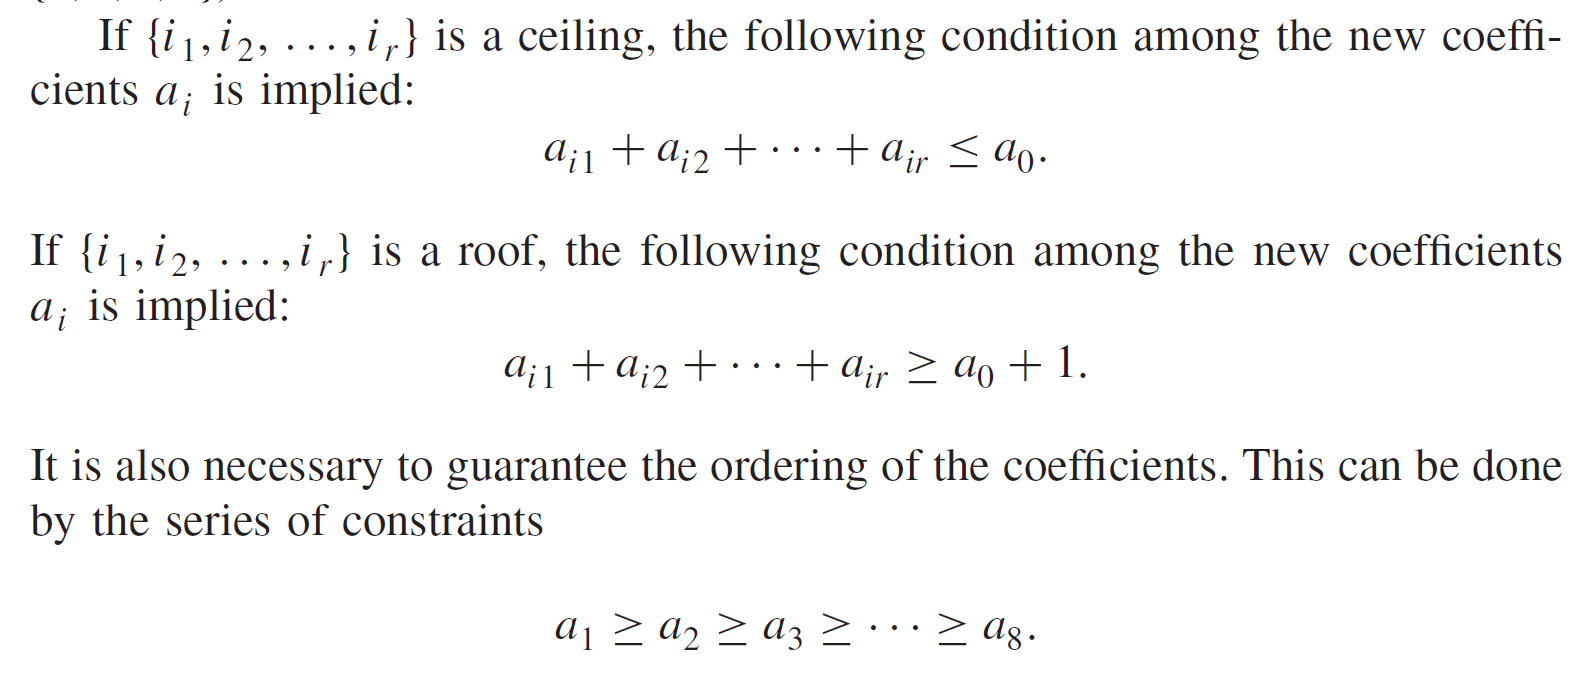

ここで求まった制約式を用いて、$a_0$ や $\sum_{i=1}^8 a_i$ を最小化するような $a_i$ を求めればよい。